**The Dataset with the audio and the sliced data can be found in this link.**
[Materials](https://drive.google.com/drive/folders/1wmcxBIE5IkBUVcQVXWjDWGP7Bd4O2CeF?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab_Notebooks/DL-Sigma2021/Deep Learning Project_SIGMA M2_2021"

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/DL-Sigma2021/Deep Learning Project_SIGMA M2_2021


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
import zipfile
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
import Code.utils as fu
import keras
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
# Load the TensorBoard notebook extension.
%load_ext tensorboard


In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16210133787785801138
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6551921320626120727
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [5]:
tf.random.set_seed(999)
np.random.seed(999)

# Import the dataset

In [14]:
train_in1 = np.load("train_1_v2.npy") 
train_out1 = np.load("train1_1_out_v2.npy")
test_in = np.load("testdataset_in_v2.npy")
test_out = np.load("testdataset_out_v2.npy")
val_in = np.load("valdataset_in_v2.npy")
val_out = np.load("valdataset_out_v2.npy")

In [16]:
# Data set normalization. The Normalization Type can be changed based on the need.
train_in1 = fu.normalization(train_in1,NormalizationType = MinMaxScaler())
train_out1 = fu.normalization(train_out1,NormalizationType = MinMaxScaler())
test_in = fu.normalization(test_in,NormalizationType = MinMaxScaler())
test_out = fu.normalization(test_out,NormalizationType = MinMaxScaler())
val_in = fu.normalization(val_in,NormalizationType = MinMaxScaler())
val_out = fu.normalization(val_out,NormalizationType = MinMaxScaler())

# We have three dataset but the validation set we created is too large, so instead we are merging it with the train and choosing
# 20% of train as validation.
# You can skip this if you don't need this.

train_in = np.concatenate((train_in1,val_in),axis=2)
train_out = np.concatenate((train_out1,val_out),axis=2)

In [17]:
# prepare training reference images: add new dimension
train_imgs_data = train_out.T[..., tf.newaxis]
train_noisy_imgs = train_in.T[..., tf.newaxis]
# prepare test reference images: add new dimension
test_imgs_data = test_out.T[..., tf.newaxis]
test_noisy_imgs = test_in.T[..., tf.newaxis]

In [18]:
print("Training input shape:", train_noisy_imgs.shape)
print("Training output shape:", train_imgs_data.shape)
print("Test input shape:", test_noisy_imgs.shape)
print("Test output shape:", test_imgs_data.shape)

Training input shape: (50554, 16, 128, 1)
Training output shape: (50554, 16, 128, 1)
Test input shape: (16076, 16, 128, 1)
Test output shape: (16076, 16, 128, 1)


# Lossless Autoencoder Model

In [19]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

IMG_SHAPE = train_imgs_data.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 2000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder_lossless = Model(inp,reconstruction)
autoencoder_lossless.compile(optimizer='adamax', loss='mse')

print(autoencoder_lossless.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 128, 1)]      0         
                                                                 
 sequential (Sequential)     (None, 2000)              4098000   
                                                                 
 sequential_1 (Sequential)   (None, 16, 128, 1)        4098048   
                                                                 
Total params: 8,196,048
Trainable params: 8,196,048
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
result_lossless = autoencoder_lossless.fit(x=train_noisy_imgs, y=train_imgs_data, epochs=20, validation_split = 0.2, workers=2, shuffle=True)

Epoch 1/20
1264/1264 [==============================] - 8s 5ms/step - loss: 0.0207 - val_loss: 0.0193
Epoch 2/20
1264/1264 [==============================] - 6s 4ms/step - loss: 0.0187 - val_loss: 0.0189
Epoch 3/20
1264/1264 [==============================] - 5s 4ms/step - loss: 0.0182 - val_loss: 0.0187
Epoch 4/20
1264/1264 [==============================] - 6s 4ms/step - loss: 0.0179 - val_loss: 0.0185
Epoch 5/20
1264/1264 [==============================] - 6s 4ms/step - loss: 0.0178 - val_loss: 0.0184
Epoch 6/20
1264/1264 [==============================] - 6s 4ms/step - loss: 0.0176 - val_loss: 0.0183
Epoch 7/20
1264/1264 [==============================] - 6s 4ms/step - loss: 0.0175 - val_loss: 0.0184
Epoch 8/20
1264/1264 [==============================] - 5s 4ms/step - loss: 0.0174 - val_loss: 0.0188
Epoch 9/20
1264/1264 [==============================] - 6s 4ms/step - loss: 0.0174 - val_loss: 0.0182
Epoch 10/20
1264/1264 [==============================] - 5s 4ms/step - loss: 0.017

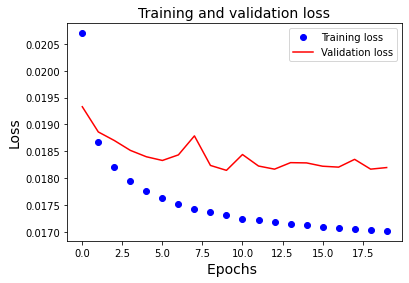

In [ ]:
# visualize train and val losses
fu.plot_losses(result_lossless)

In [20]:
# Save the model
# autoencoder_lossless.save_weights('autoencoder_lossless_v1.h5')
# autoencoder_lossless.load_weights('autoencoder_lossless_v1.h5')

# Classical or Lossy Autoencoder Model

In [21]:
# define leaky ReLU function
def lrelu(x, alpha=0.1):
    return tf.math.maximum(alpha*x, x)

nbfilter = 32
encoder = Sequential([
    # convolution
    Conv2D(
        filters=nbfilter,
        kernel_size=(3,3),
        strides=(1,1),
        padding='SAME',
        use_bias=True,
        activation=lrelu,
        name='conv1'
    ),
    
    MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2),
        name='pool1'
    )  
])

decoder = Sequential([
    Conv2DTranspose(
        filters=nbfilter,
        kernel_size=3,
        padding='same',
        strides=2,
        name='upsample1'
    ),    
    Conv2D(
        filters=1,
        kernel_size=(3,3),
        strides=(1,1),
        name='logits',
        padding='SAME',
        use_bias=True
    )
])

# model class definition
class EncoderDecoderModel(Model):
    def __init__(self, is_sigmoid=False):
        super(EncoderDecoderModel, self).__init__()
        # assign encoder sequence
        self._encoder = encoder
        # assign decoder sequence 
        self._decoder = decoder
        self._is_sigmoid = is_sigmoid
        
    # forward pass
    def call(self, x):
        x = self._encoder(x)
        decoded = self._decoder(x)
        if self._is_sigmoid:
            decoded = tf.keras.activations.sigmoid(decoded)
            # decoded = tf.keras.activations.tanh(decoded)
        return decoded

# init the model
autoencoder_lossy = EncoderDecoderModel()
num_epochs = 32
batch_size_to_set = 64

# training process params
learning_rate = 1e-5
# default number of workers for training process
num_workers = 2

# initialize the training configurations such as optimizer, loss function and accuracy metrics
autoencoder_lossy.compile(optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
                              ,loss="mse" ,metrics=None)

In [23]:
results_lossy = autoencoder_lossy.fit(
    train_noisy_imgs,
    train_imgs_data,
    epochs=num_epochs,
    batch_size=batch_size_to_set,
    validation_split = 0.2,
    # validation_data=(test_noisy_imgs, test_imgs_data),
    workers=num_workers,
    shuffle=True
)

Epoch 1/32
632/632 [==============================] - 19s 12ms/step - loss: 0.0304 - val_loss: 0.0230
Epoch 2/32
632/632 [==============================] - 6s 10ms/step - loss: 0.0219 - val_loss: 0.0219
Epoch 3/32
632/632 [==============================] - 6s 10ms/step - loss: 0.0214 - val_loss: 0.0216
Epoch 4/32
632/632 [==============================] - 6s 10ms/step - loss: 0.0211 - val_loss: 0.0214
Epoch 5/32
632/632 [==============================] - 6s 10ms/step - loss: 0.0209 - val_loss: 0.0211
Epoch 6/32
632/632 [==============================] - 6s 10ms/step - loss: 0.0207 - val_loss: 0.0209
Epoch 7/32
632/632 [==============================] - 6s 10ms/step - loss: 0.0205 - val_loss: 0.0208
Epoch 8/32
632/632 [==============================] - 6s 10ms/step - loss: 0.0204 - val_loss: 0.0207
Epoch 9/32
632/632 [==============================] - 6s 10ms/step - loss: 0.0203 - val_loss: 0.0206
Epoch 10/32
632/632 [==============================] - 6s 10ms/step - loss: 0.0202 - val_l

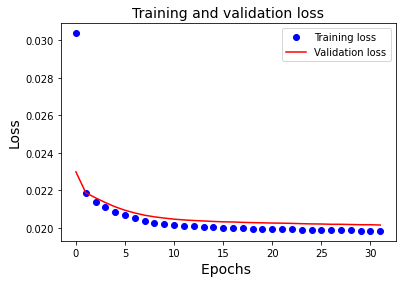

In [ ]:
# visualize train and val losses
fu.plot_losses(results_lossy)

In [24]:
# Saving the model
# autoencoder_lossy.save_weights('autoencoder_lossy_v1.h5')
# autoencoder_lossy.load_weights('autoencoder_lossy_v1.h5')

# Now it's time to test what we OBTAINED

In [25]:
predict_train_lossy = autoencoder_lossy.predict(train_noisy_imgs)
predict_train_lossless = autoencoder_lossless.predict(train_noisy_imgs)

predict_test_lossy = autoencoder_lossy.predict(test_noisy_imgs)
predict_test_lossless = autoencoder_lossless.predict(test_noisy_imgs)

## SNR Measurment

In [ ]:
# SNR for Training set
psnr_train_predict_lossy = fu.snr_avg(train_imgs_data, predict_train_lossy)
psnr_train_predict_lossless = fu.snr_avg(train_imgs_data, predict_train_lossless)
psnr_train = fu.snr_avg(train_imgs_data, train_noisy_imgs)
print("SNR before implying the DNN:",psnr_train)
print("SNR based on the result of the classical autoencoder",psnr_train_predict_lossy)
print("SNR based on the result of the lossless autoencoder",psnr_train_predict_lossless)

SNR before implying the DNN: 20.042957433544213
SNR based on the result of the classical autoencoder 18.379347326437266
SNR based on the result of the lossless autoencoder 19.246123089057324


In [ ]:
# SNR for Test set
psnr_test_predict_lossy = fu.snr_avg(test_imgs_data, predict_test_lossy)
psnr_test_predict_lossless = fu.snr_avg(test_imgs_data, predict_test_lossless)
psnr_test = fu.snr_avg(test_imgs_data, test_noisy_imgs)
print("SNR before implying the DNN for the testset:",psnr_test)
print("SNR based on the result of the classical autoencoder",psnr_test_predict_lossy)
print("SNR based on the result of the lossless autoencoder",psnr_test_predict_lossless)

SNR before implying the DNN for the testset: 19.881106364875098
SNR based on the result of the classical autoencoder 18.331177043478235
SNR based on the result of the lossless autoencoder 18.970563261994677


## An example of the result

Text(0.5, 1.0, 'Prediction_Lossless')

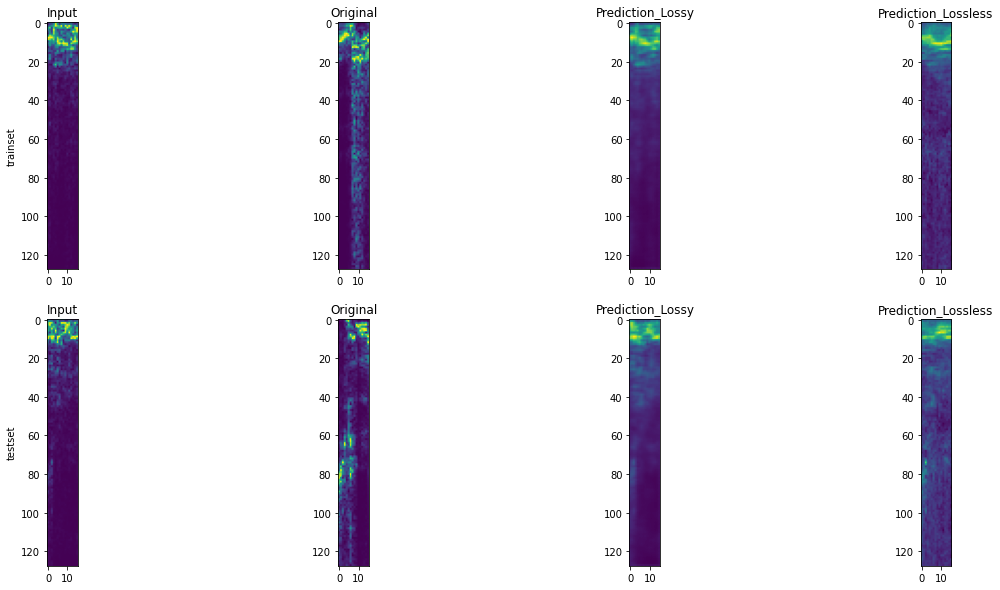

In [ ]:
k = 438
plt.figure(figsize=(20,10))
plt.subplot(241)
plt.imshow(train_noisy_imgs[k,:,:,:].reshape((16,128)).T)
plt.title("Input")
plt.ylabel("trainset")
plt.subplot(242)
plt.imshow(train_imgs_data[k,:,:,:].reshape((16,128)).T)
plt.title("Original")
plt.subplot(243)
plt.imshow(predict_train_lossy[k,:,:,:].reshape((16,128)).T)
plt.title("Prediction_Lossy")
plt.subplot(244)
plt.imshow(predict_train_lossless[k,:,:,:].reshape((16,128)).T)
plt.title("Prediction_Lossless")


plt.subplot(245)
plt.imshow(test_noisy_imgs[k,:,:,:].reshape((16,128)).T)
plt.title("Input")
plt.ylabel("testset")
plt.subplot(246)
plt.imshow(test_imgs_data[k,:,:,:].reshape((16,128)).T)
plt.title("Original")
plt.subplot(247)
plt.imshow(predict_test_lossy[k,:,:,:].reshape((16,128)).T)
plt.title("Prediction_Lossy")
plt.subplot(248)
plt.imshow(predict_test_lossless[k,:,:,:].reshape((16,128)).T)
plt.title("Prediction_Lossless")


## Reverting Process I (Slices to a complete STFT)

In [26]:
# Initalization Parameters
windowLength = 255
overlap      = round(0.5 * windowLength) # overlap of 50%
ffTLength    = windowLength
inputFs      = 16e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 16
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 255
overlap: 128
ffTLength: 255
inputFs: 16000.0
fs: 16000.0
numFeatures: 128
numSegments: 16


In [27]:
# Testing on an audio
filenb = 234
clean_path = './dataset/speech_TRAIN_2/clean_TRAIN_2/'
cfr = fu.files_record(clean_path)
cfr.sort()
noisy_path = './dataset/speech_TRAIN_2/noisy_TRAIN_2/'
nfr = fu.files_record(noisy_path)
nfr.sort()
print(cfr[filenb], nfr[filenb])

./dataset/speech_TRAIN_2/clean_TRAIN_2/SI1702.WAV ./dataset/speech_TRAIN_2/noisy_TRAIN_2/SI1702.WAV


In [28]:
# Readin the clean and noisy audio transfer it to the stft domain
Audio_c, sr_c = fu.read_audio(os.path.join(cfr[filenb]), sample_rate=fs)
AudioFeatureExtractor_c = fu.FeatureExtractor(Audio_c, windowLength=windowLength, overlap=overlap, sample_rate=sr_c)
stft_features_c = AudioFeatureExtractor_c.get_stft_spectrogram()

Audio_n, sr_n = fu.read_audio(os.path.join(nfr[filenb]), sample_rate=fs)
AudioFeatureExtractor_n = fu.FeatureExtractor(Audio_n, windowLength=windowLength, overlap=overlap, sample_rate=sr_n)
stft_features_n = AudioFeatureExtractor_n.get_stft_spectrogram()

In [29]:
# Prepare the audio stft for prediction
test_data = fu.built_dataset(nfr[filenb])
test_data = fu.normalization(test_data ,NormalizationType=MinMaxScaler())
test_data = test_data.T[..., tf.newaxis]
test_data.shape

(15, 16, 128, 1)

In [30]:
# Apply the models
predict_lossy = autoencoder_lossy.predict(test_data)
predict_lossless = autoencoder_lossless.predict(test_data)

In [31]:
# Concatinate the output slices
m,n,h = np.size(test_data,0), np.size(test_data,1), np.size(test_data,2)
test_stft_lossy = np.zeros((int(m*n),h))
test_stft_lossless = np.zeros((int(m*n),h))
for i in range(m):
  if i == 0:
    test_stft_lossy[i*(n):i*(n)+n,:] = predict_lossy[i,:,:,0]
    test_stft_lossless[i*(n):i*(n)+n,:] = predict_lossless[i,:,:,0]
  else:
    a1_1 = predict_lossy[i-1,n-1,:,0]
    a2_1 = predict_lossy[i,0,:,0]
    a3_1 = np.zeros_like(a1_1)

    a1_2 = predict_lossless[i-1,n-1,:,0]
    a2_2 = predict_lossless[i,0,:,0]
    a3_2 = np.zeros_like(a1_2)
    for j in range(h):
      a3_1[j] = np.mean([a1_1[j],a2_1[j]])
      a3_2[j] = np.mean([a1_2[j],a2_2[j]])
    
    predict_lossy[i-1,n-1,:,0] = a3_1
    predict_lossless[i-1,n-1,:,0] = a3_2

    predict_lossy[i,0,:,0] = a3_1
    predict_lossless[i,0,:,0] = a3_2

    test_stft_lossy[i*(n):i*(n)+n,:] = predict_lossy[i,:,:,0]
    test_stft_lossless[i*(n):i*(n)+n,:] = predict_lossless[i,:,:,0]

Text(0.5, 1.0, 'predicted lossless stft')

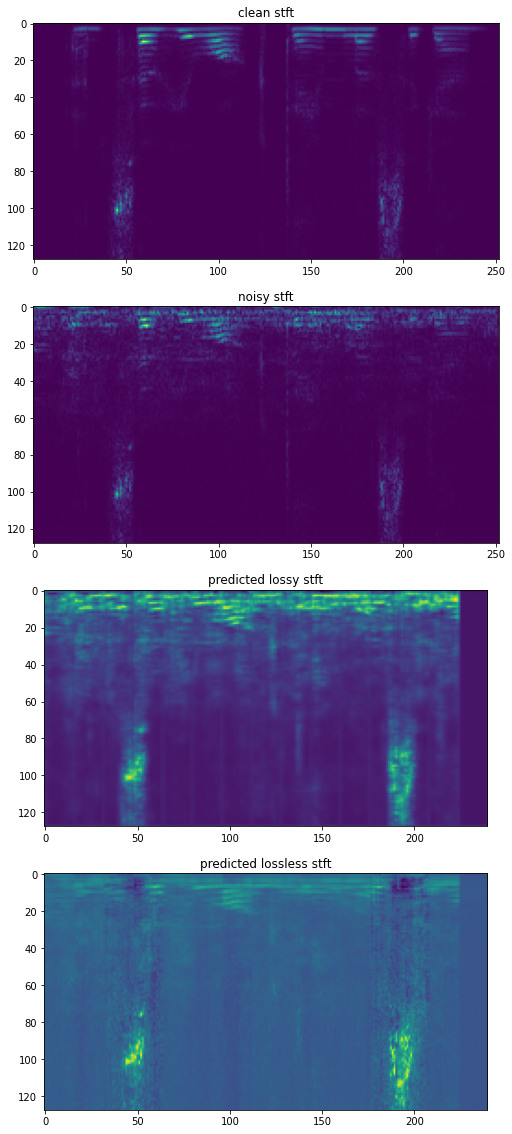

In [ ]:
plt.figure(figsize=(10,20))

plt.subplot(411)
# plt.imshow(fu.normalization(np.abs(stft_features_c[2]), NormalizationType=MinMaxScaler()))
plt.imshow(np.abs(stft_features_c[2]))
plt.title("clean stft")
plt.subplot(412)
# plt.imshow(fu.normalization(np.abs(stft_features_n[2]), NormalizationType=MinMaxScaler()))
plt.imshow(np.abs(stft_features_n[2]))

plt.title("noisy stft")
plt.subplot(413)
plt.imshow(test_stft_lossy.T)
# plt.imshow(fu.normalization(test_stft_org.T, NormalizationType= MinMaxScaler()))
plt.title("predicted lossy stft")

plt.subplot(414)
plt.imshow(test_stft_lossless.T)
# plt.imshow(fu.normalization(test_stft_lossless.T, NormalizationType= MinMaxScaler()))
plt.title("predicted lossless stft")

## Reverting Process II (STFT to Audio)

In [35]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the output back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    features = features * np.exp(1j * phase)  # that fixes the abs() previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram2(features)

In [36]:
noisyPhase = np.angle(stft_features_c[2][:,:np.size(test_stft_lossy,0)])
noiseAudioFeatureExtractor = fu.FeatureExtractor(Audio_c, windowLength=windowLength, overlap=overlap, sample_rate=sr_c)
_,denoisedAudio_lossy = revert_features_to_audio(
                                          test_stft_lossy
                                          # normalization(test_stft_org, NormalizationType=MinMaxScaler())
                                          , noisyPhase
                                         )
_,denoisedAudio_lossless = revert_features_to_audio(
                                          test_stft_lossless
                                          # normalization(test_stft_org, NormalizationType=MinMaxScaler())
                                          , noisyPhase
                                         )
print("Min:", np.min(denoisedAudio_lossy),"Max:",np.max(denoisedAudio_lossy))
print("Min:", np.min(denoisedAudio_lossless),"Max:",np.max(denoisedAudio_lossless))

Min: -11.724337794999538 Max: 18.439537722974602
Min: -18.40222380787907 Max: 23.07220210014475


In [ ]:
# Playing the clean Audio
ipd.Audio(data=Audio_c, rate=sr_c) # Clean Audio

In [ ]:
# Playing Noisy Audio
ipd.Audio(data=Audio_n, rate=sr_n) # Noisy Audio

In [ ]:
# Playing the predicted with lossy autoencoder
ipd.Audio(data=denoisedAudio_lossy, rate=fs) # DNN

In [ ]:
# Playing the predicted with lossless autoencoder
ipd.Audio(data=denoisedAudio_lossless, rate=fs) # DNN

In [45]:
# Saving the results
import scipy.io.wavfile as wv
import soundfile as sf

wv.write('clean.mp3',int(fs),Audio_c)
wv.write('noisy.mp3',int(fs),Audio_n)
# wv.write("denoisedDNN_lossy.mp3",int(fs),denoisedAudio_lossy)
# wv.write("denoisedDNN_lossless.mp3",int(fs),denoisedAudio_lossless)

sf.write("denoisedDNN_lossy.wav",denoisedAudio_lossy,int(fs))
sf.write("denoisedDNN_lossless.wav",denoisedAudio_lossless,int(fs))